In [1]:
%matplotlib inline

In [2]:
from typing import List, Union

from qiskit import pulse
from qiskit.pulse.reschedule import pad
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.pulse import Schedule, DriveChannel, MeasureChannel, FrameChange, Delay

import numpy as np

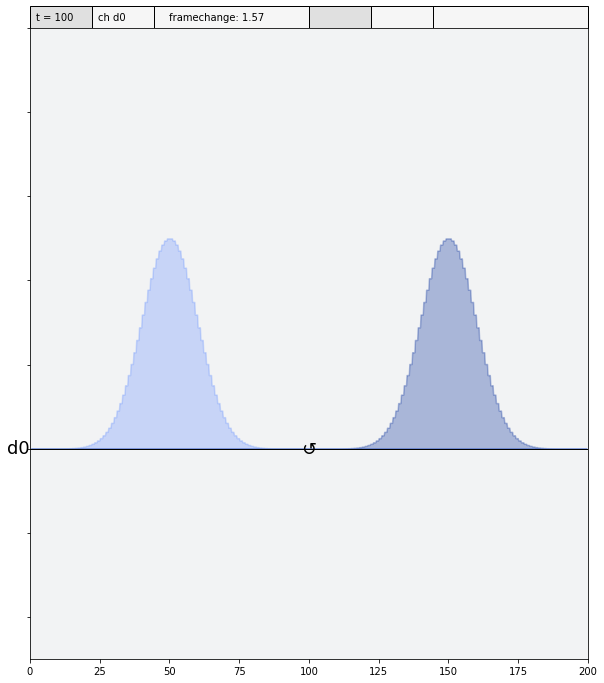

In [3]:
sched = Schedule()
f = pulse_lib.gaussian(100, 1.0, 10.0)
sched += f(DriveChannel(0))
sched += FrameChange(np.pi/2)(DriveChannel(0))
sched |= f(DriveChannel(0)).shift(100)
sched.draw()

In [4]:
ramsey = pulse.Schedule()
x90 = pulse_lib.gaussian_square(100, 0.5j, 50, 20)
ramsey += x90(DriveChannel(0))
ramsey += Delay(100)(DriveChannel(0))
ramsey += x90(DriveChannel(0))
ramsey += x90(DriveChannel(1)) << 200
align = [f(DriveChannel(0)), f(DriveChannel(0)), ramsey, f(DriveChannel(1))]

# Align left

In [46]:
def push_append(this: List[pulse.ScheduleComponent], 
                other: List[pulse.ScheduleComponent]) -> pulse.Schedule:
        r"""Return a new schedule with `schedule` inserted at the maximum time over
        all channels shared between `self` and `schedule`.

       $t = \textrm{max}({x.stop\_time |x \in self.channels \cap schedule.channels})$

        Args:
            schedule: schedule to be appended
            buffer: Whether to obey buffer when appending
        """
        other_channels = other.channels
        
        channels = {}
        min_ch_slack = np.inf
        max_common_time = this.ch_stop_time(*other_channels)
        ch_slacks = [this.ch_stop_time(channel)+other.ch_start_time(channel) 
                     for channel in other_channels]
           
        insert_time = this.start_time + max(ch_slacks, default=0)
        return this.insert(insert_time, other)
    
def align_left(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]) -> pulse.Schedule:
    """Align a list of pulse instructions on the left
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = pulse.Schedule()
    for instruction in instructions:
        aligned = push_append(aligned, instruction)
    
    return aligned

def left_barrier(*instructions: List[pulse.ScheduleComponent],
                       channels=None) -> pulse.Schedule:
    """Align on the left and create a barrier so that pulses cannot be inserted within this pulse interval
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = align_left(*instructions)
    return pad(aligned, channels=channels)

def align_right(*instructions: List[pulse.ScheduleComponent]) -> pulse.Schedule:
    """Align a list of pulse instructions on the right
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    left_aligned = align_left(*instructions)
    max_duration = 0
    
    channel_durations = {}
    for channel in left_aligned.channels:
        channel_sched = left_aligned.filter(channels=[channel])
        channel_duration = channel_sched.duration-channel_sched.start_time
        channel_durations[channel] = channel_sched.duration
        max_duration = max(max_duration, channel_duration)
    
    aligned = pulse.Schedule()
    for instr_time, instruction in left_aligned.instructions:
        instr_max_dur = max(channel_durations[channel] for channel in instruction.channels)
        instr_delayed_time = max_duration - instr_max_dur + instr_time
        aligned.insert(instr_delayed_time, instruction, mutate=True)
        
    return aligned

def right_barrier(*instructions: List[pulse.ScheduleComponent],
                       channels=None) -> pulse.Schedule:
    """Align on the right and create a barrier so that pulses cannot be inserted within this pulse interval
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = align_right(*instructions)
    return pad(aligned, channels=channels)

def align_in_sequence(*instructions: List[pulse.ScheduleComponent]) -> pulse.Schedule:
    """Align a list of pulse instructions sequentially in time.
    Args:
        instructions: List of pulse instructions to align.
    Returns:
        A new pulse schedule with instructions`
    """
    aligned = pulse.Schedule()
    for instruction in instructions:
        aligned.insert(aligned.duration, instruction, mutate=True)
    return aligned

0 0 (DriveChannel(0),) [0]
100 0 (DriveChannel(0),) [100]
200 0 (DriveChannel(0), DriveChannel(1)) [200, 200]
500 0 (DriveChannel(1),) [500]


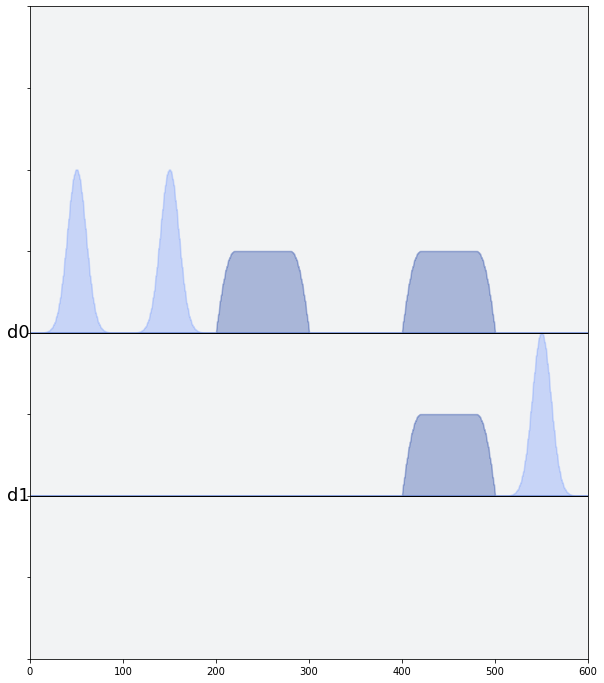

In [52]:
align_left(*align).draw()

In [51]:
pre_al = align_left(*align)

0 0 (DriveChannel(0),) [0]
100 0 (DriveChannel(0),) [100]
200 0 (DriveChannel(0), DriveChannel(1)) [200, 200]
500 0 (DriveChannel(1),) [500]


0 0 (DriveChannel(0),) [0]
100 0 (DriveChannel(0),) [100]
200 0 (DriveChannel(0), DriveChannel(1)) [200, 200]
500 0 (DriveChannel(1),) [500]


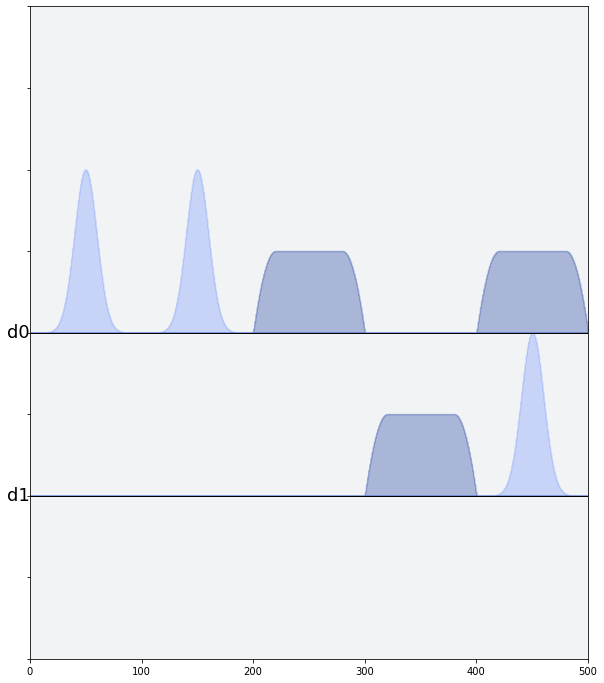

In [50]:
aligned_right = align_right(*align)
aligned_right.draw()

0 0 (DriveChannel(0),) [0]
100 0 (DriveChannel(0),) [100]
200 0 (DriveChannel(0), DriveChannel(1)) [200, 200]
500 0 (DriveChannel(1),) [500]


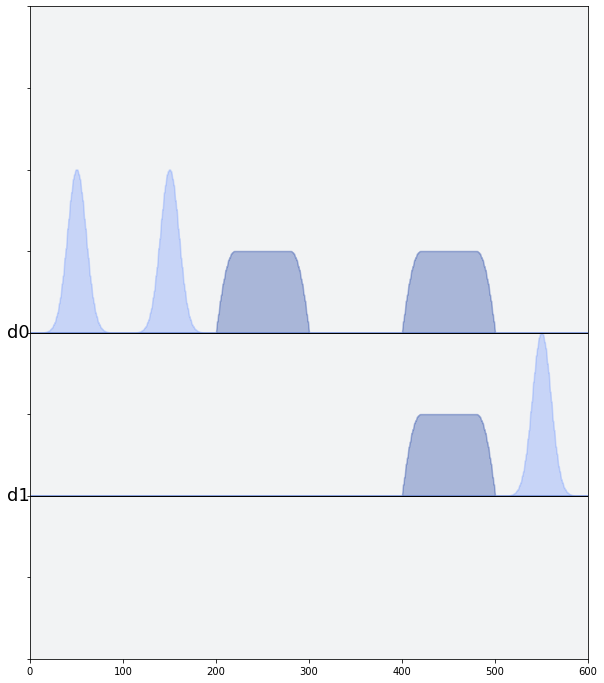

In [49]:
left_barrier(*align).draw()

0 0 (DriveChannel(0),) [0]
100 0 (DriveChannel(0),) [100]
200 0 (DriveChannel(0), DriveChannel(1)) [200, 200]
500 0 (DriveChannel(1),) [500]


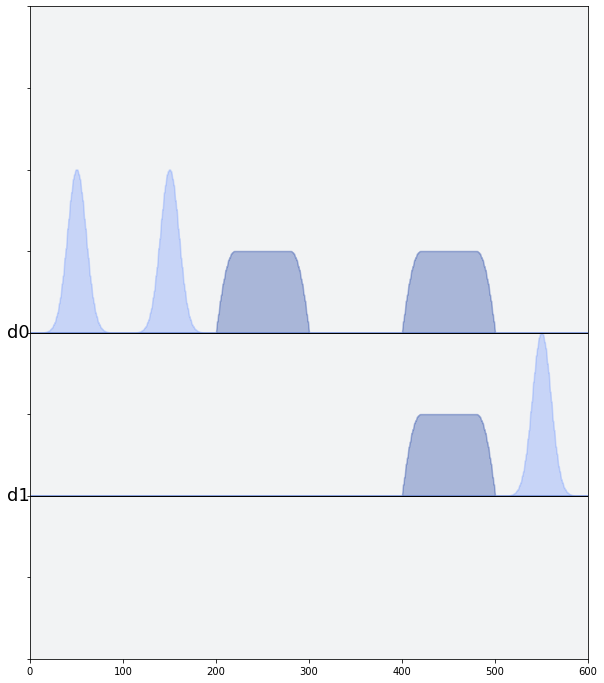

In [48]:
lefty = left_barrier(*align)
lefty.draw()

0 0 (DriveChannel(1),) [0]
0 0 (DriveChannel(1),) [0]
100 0 (DriveChannel(0), DriveChannel(1)) [0, 100]


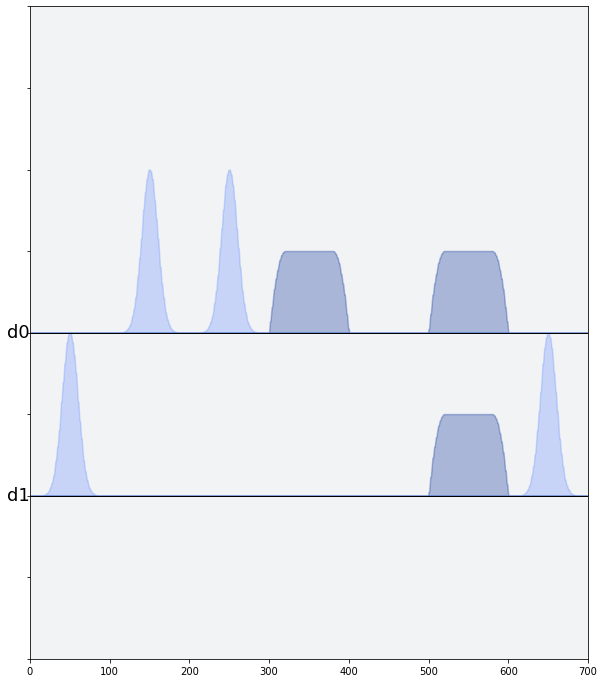

In [47]:

barriered_left = left_barrier(left_barrier(f(DriveChannel(1))), lefty)
barriered_left.draw()

0 0 (DriveChannel(0),) [0]
100 0 (DriveChannel(0),) [100]
200 0 (DriveChannel(0), DriveChannel(1)) [200, 200]
500 0 (DriveChannel(1),) [500]


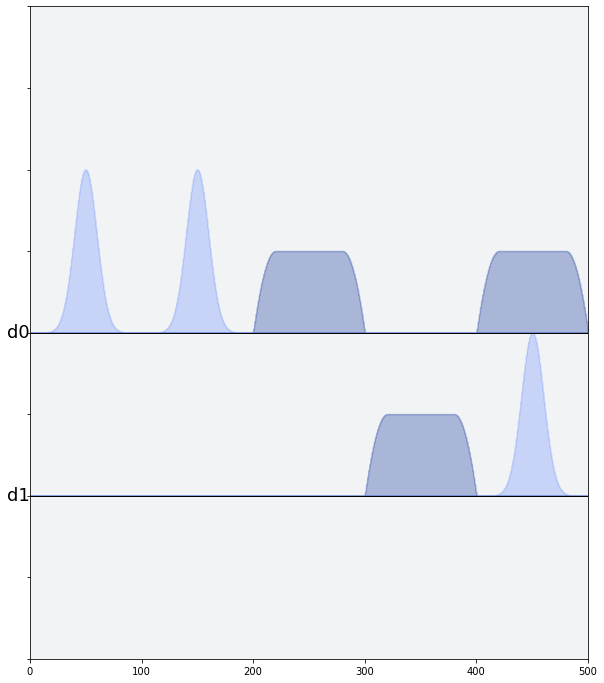

In [43]:
aligned_right = right_barrier(*align)
aligned_right.draw()

In [44]:
barriered_left = left_barrier(f(DriveChannel(1)), left_barrier(*align))
barriered_left.draw()

0 0 (DriveChannel(0),) [0]
100 0 (DriveChannel(0),) [100]
200 0 (DriveChannel(0), DriveChannel(1)) [200, 200]
500 0 (DriveChannel(1),) [500]
0 0 (DriveChannel(1),) [0]
0 0 (DriveChannel(0), DriveChannel(1)) [0, 100]


PulseError: 'Schedules overlap: Overlap on channel DriveChannel(1) over time range [0, 100] for Schedule(name="None", duration=100), Schedule(name="None", duration=600)'

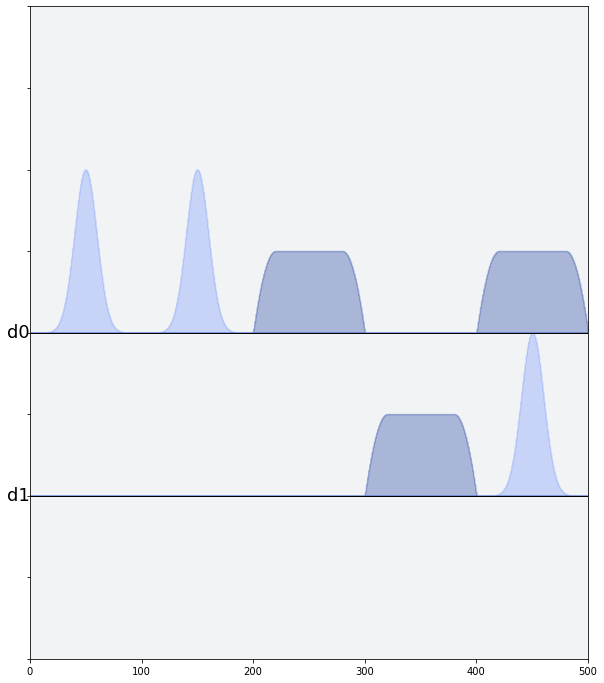

In [12]:
barriered_right = right_barrier(*align)
barriered_right.draw()

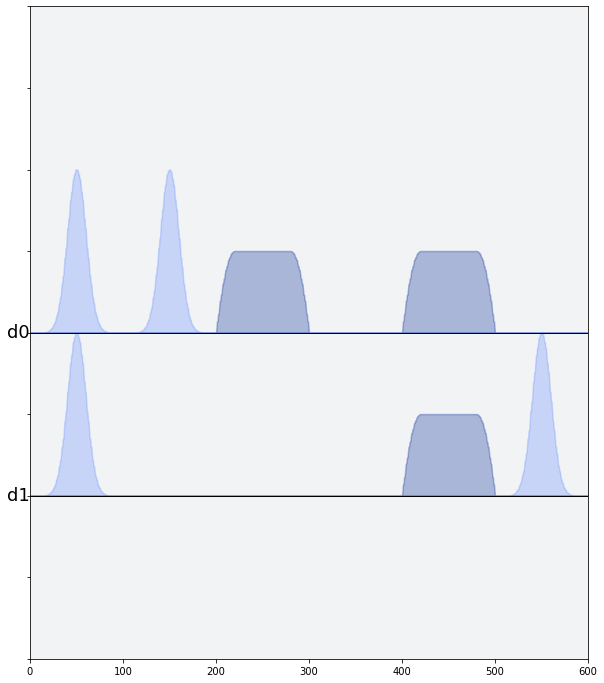

In [13]:
barriered_left = left_barrier(f(DriveChannel(1)), *align)
barriered_left.draw()

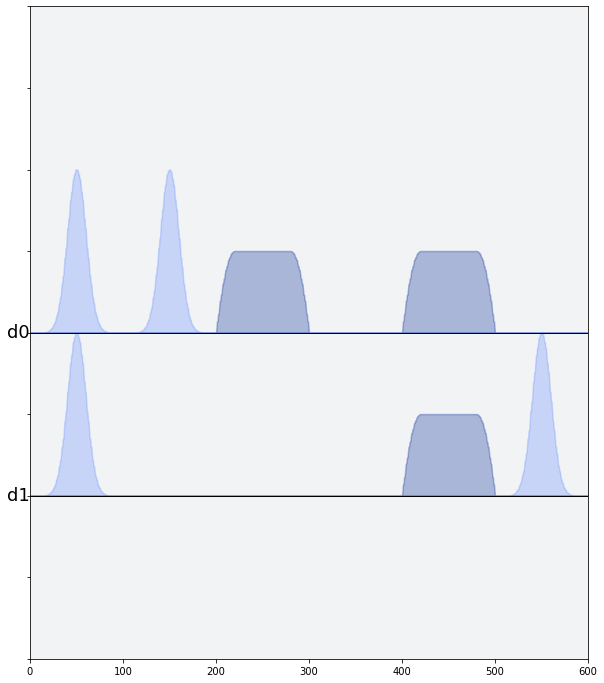

In [14]:
aligned_left = align_left(f(DriveChannel(1)), pre_al)
aligned_left.draw()

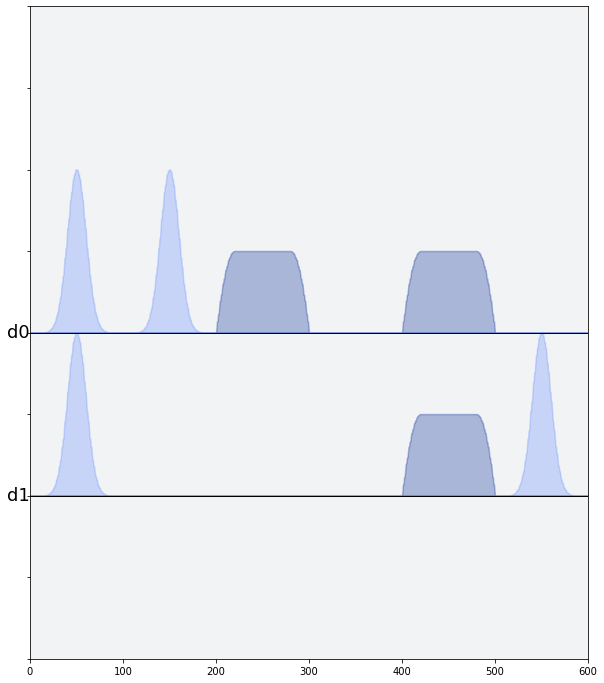

In [15]:
aligned_left_padded = left_barrier(f(DriveChannel(1)), *align)
aligned_left_padded.draw()

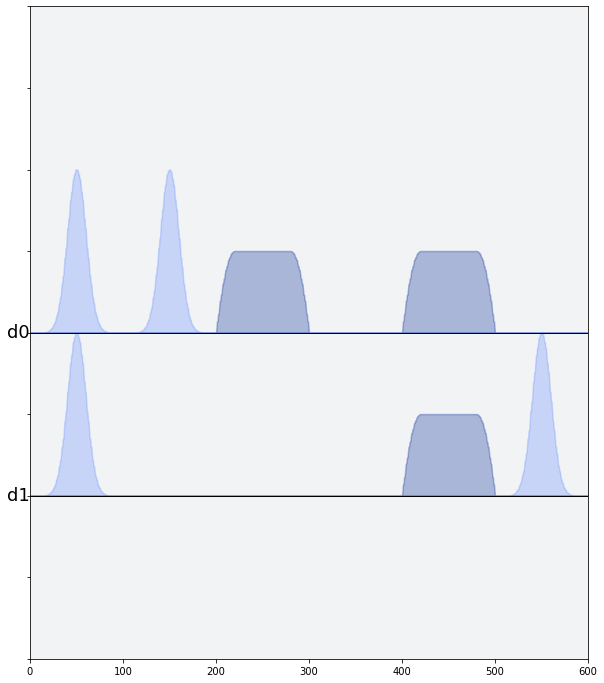

In [16]:
aligned_left_padded = left_barrier(f(DriveChannel(1)), *align)
aligned_left_padded.draw()

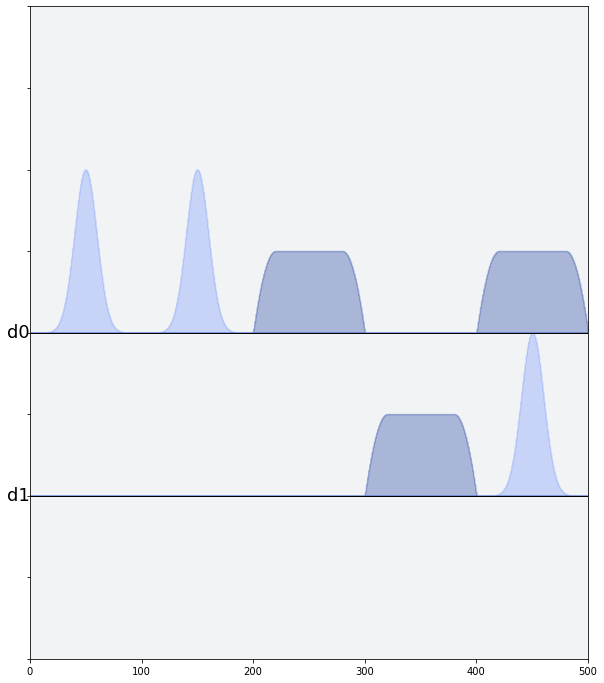

In [17]:
aligned_right_padded = right_barrier(*align)
aligned_right_padded.draw()

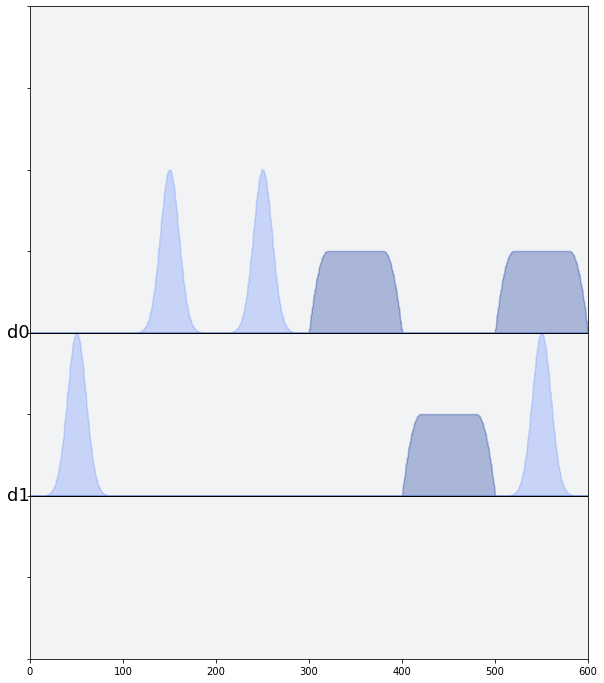

In [18]:
added =  f(DriveChannel(1)) + aligned_right_padded 
added.draw()

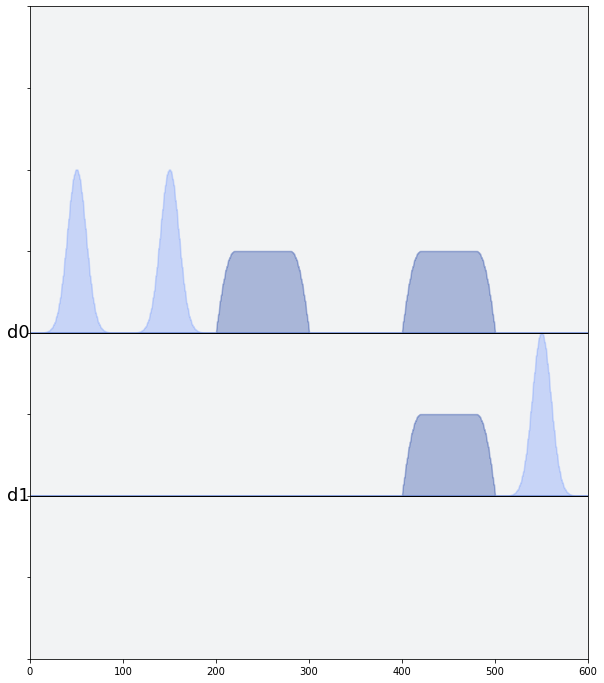

In [19]:
align_in_sequence(*align).draw()